In [2]:
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
import random
import os

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sksurv.preprocessing import OneHotEncoder
from sklearn_pandas import DataFrameMapper

import torch
import torch.nn as nn
import torchtuples as tt

from torchtuples.callbacks import EarlyStopping
from sklearn.neural_network import MLPClassifier
from torch.utils.data import Dataset, DataLoader

In [3]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

In [4]:
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

In [5]:
# det dummy
dummy_f = ['REGION','MARST', 'RACEA', 'USBORN', 'HSTATYR', 'ALCSTAT1', 'SMOKESTATUS2']
df_train[dummy_f] = df_train[dummy_f].astype(int)
df_test[dummy_f] = df_test[dummy_f].astype(int)
df_val[dummy_f] = df_val[dummy_f].astype(int)
df_train = pd.get_dummies(df_train, columns=dummy_f, prefix=dummy_f).astype(int)
df_val = pd.get_dummies(df_val, columns=dummy_f, prefix=dummy_f).astype(int)
df_test = pd.get_dummies(df_test, columns=dummy_f, prefix=dummy_f).astype(int)

In [6]:
# list of columns to standardize
cols_stand = ['AGE', 'BMICALC', 'HRSLEEP']
              
cols_norm = ['FAMSIZE', 'EDUCREC1', 'POVERTY', 'FSRAWSCORE', 'ALC5UPYR', 'ALCAMT', 'ALCDAYSYR',
              'CIGSDAY', 'MOD10DMIN', 'MOD10FWK', 'VIG10DMIN', 'VIG10FWK', 'STRONGFWK', 'AEFFORT', 
              'AFEELINT1MO', 'AWORTHLESS', 'WRYMEDCST', 'WRYRET',
              'SEX', 'HINOTCOVE', 'HIPRIVATEE', 'HIMCAIDE', 'HIMCAREE', 'ARTHGLUPEV',
              'BLIND', 'CANCEREV', 'CHEARTDIEV', 'CPOXEV', 'DIABETICEV', 'EMPHYSEMEV',
              'HEARTATTEV', 'HEARTCONEV', 'HYPERTENEV', 'KIDNEYWKYR', 'LIVERCHRON',
              'LIVERCONYR', 'STROKEV']

# list of columns not to standardize
cols_leave = [col for col in df_train.columns if col not in cols_stand + cols_norm + ['TIMETOEVENT', 'MORTSTAT']]

# create mapper entries
standardize = [([col], StandardScaler()) for col in cols_stand]
normalize = [([col], MinMaxScaler()) for col in cols_norm]
leave = [(col, None) for col in cols_leave]

# combine into one mapper
x_mapper = DataFrameMapper(standardize + normalize + leave, df_out=False)

# prepare X matrices
x_train = df_train.drop(columns=['MORTSTAT', 'TIMETOEVENT'])
x_val = df_val.drop(columns=['MORTSTAT', 'TIMETOEVENT'])
x_test = df_test.drop(columns=['MORTSTAT', 'TIMETOEVENT'])

In [7]:
# get the transformed column names by matching them to the original columns
transformed_column_names = cols_stand + cols_norm + cols_leave
x_train_df_transformed = pd.DataFrame(x_train, columns=transformed_column_names)
feature_names= list(x_train_df_transformed.columns)

In [8]:
# transform with DataFrameMapper and convert to PyTorch tensors
x_train = torch.tensor(x_mapper.fit_transform(df_train.drop(columns=['MORTSTAT', 'TIMETOEVENT'])), dtype=torch.float32)
x_val = torch.tensor(x_mapper.transform(df_val.drop(columns=['MORTSTAT', 'TIMETOEVENT'])), dtype=torch.float32)
x_test = torch.tensor(x_mapper.transform(df_test.drop(columns=['MORTSTAT', 'TIMETOEVENT'])), dtype=torch.float32)

In [9]:
# define three-year mortality status as PyTorch tensors
y_train = torch.tensor(np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 3), 1, 0), dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(np.where((df_val["MORTSTAT"] == 1) & (df_val["TIMETOEVENT"] <= 3), 1, 0), dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 3), 1, 0), dtype=torch.float32).view(-1, 1)

In [10]:
# set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)


# define the network
in_features = x_train.shape[1]
net = tt.practical.MLPVanilla(in_features, [32], 1, activation=nn.ReLU, dropout=0.5)


# model and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
model = tt.Model(net, loss_fn, tt.optim.Adam)  
model.optimizer.set_lr(0.010)  


# training setup      batch size=800, epochs=60, lr=0.005, dropout=0.2, num nodes=[32]
batch_size = 800
epochs = 60
checkpoint_path = 'best_model.pt'
# early stopping
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
callbacks = [EarlyStopping(patience=20, file_path=checkpoint_path)]

# fit
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, val_data=(x_test, y_test), 
                shuffle=True, callbacks=callbacks, verbose=True)

0:	[0s / 0s],		train_loss: 0.2632,	val_loss: 0.1127
1:	[0s / 0s],		train_loss: 0.1220,	val_loss: 0.1098
2:	[0s / 0s],		train_loss: 0.1188,	val_loss: 0.1094
3:	[0s / 0s],		train_loss: 0.1169,	val_loss: 0.1087
4:	[0s / 0s],		train_loss: 0.1166,	val_loss: 0.1086
5:	[0s / 1s],		train_loss: 0.1163,	val_loss: 0.1086
6:	[0s / 1s],		train_loss: 0.1165,	val_loss: 0.1080
7:	[0s / 1s],		train_loss: 0.1152,	val_loss: 0.1080
8:	[0s / 1s],		train_loss: 0.1157,	val_loss: 0.1079
9:	[0s / 1s],		train_loss: 0.1156,	val_loss: 0.1076
10:	[0s / 1s],		train_loss: 0.1150,	val_loss: 0.1076
11:	[0s / 2s],		train_loss: 0.1153,	val_loss: 0.1078
12:	[0s / 2s],		train_loss: 0.1152,	val_loss: 0.1086
13:	[0s / 2s],		train_loss: 0.1147,	val_loss: 0.1078
14:	[0s / 2s],		train_loss: 0.1150,	val_loss: 0.1078
15:	[0s / 2s],		train_loss: 0.1144,	val_loss: 0.1076
16:	[0s / 3s],		train_loss: 0.1142,	val_loss: 0.1075
17:	[0s / 3s],		train_loss: 0.1145,	val_loss: 0.1078
18:	[0s / 3s],		train_loss: 0.1137,	val_loss: 0.1077
19:

In [11]:
means_stds = {
    col: {
        'mean': scaler.mean_[0], 
        'std': np.sqrt(scaler.var_[0]) 
    }
    for cols, scaler in x_mapper.features
    if scaler is not None and isinstance(scaler, StandardScaler)
    for col in cols
}

In [12]:
def fit_and_plot_pdp_standadized(model, x, y, feature_index, feature_name, dots, ymin, ymax):

    # select the feature range
    feature_values = np.sort(np.unique(x_train[:, feature_index]))
    x_np = x.detach().cpu().numpy() if torch.is_tensor(x_test) else x_test
    y_np = y.detach().cpu().numpy() if torch.is_tensor(y_test) else y_test

    # compute PDP by varying the selected feature
    pdp_values = []
    x_temp = x_np.copy()
    
    for val in feature_values:
        x_temp[:, feature_index] = val  
        preds = model.predict(torch.tensor(x_temp, dtype=torch.float32)).numpy().squeeze()
        probs = 1 / (1 + np.exp(-preds))  
        pdp_values.append(probs.mean())
    
    # PDP plot pairs
    x_values = feature_values
    average_values = pdp_values
    
    plt.figure(figsize=(5, 4))
    plt.plot(x_values, average_values, color='blue', linestyle='-')
    plt.xlabel(feature, fontsize=9)
    plt.yticks(fontsize=8)
    
    mean = means_stds[feature]['mean']
    std = means_stds[feature]['std']
    # get the standardized and real x-axis values
    ticks_std = np.sort(np.unique(x_train[:, feature_index]))
    ticks_real = mean + std * ticks_std
    # get every second integer tick in the real (unstandardized) space
    min_tick = round(np.round(ticks_real.min()))
    max_tick = round(np.round(ticks_real.max()))
    tick_locs_real = np.arange(min_tick, max_tick + 1, dots)  # every 2 units
    # convert back to standardized for tick positions
    tick_locs_std = (tick_locs_real - mean) / std
    # set x-axis ticks
    plt.xticks(tick_locs_std, [str(tick) for tick in tick_locs_real], fontsize=8)
    plt.ylabel('partial dependence\n(estimated death probability)', fontsize=8)
    plt.grid(alpha=0.6)
    plt.ylim(ymin, ymax) 
    plt.savefig(f"pdp_dsc_{feature}.jpg", format="jpg", dpi=300, bbox_inches='tight')   
    plt.show()

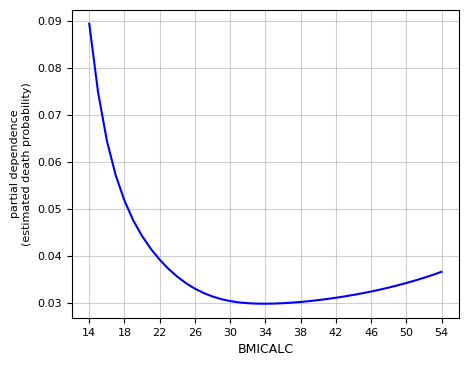

In [13]:
feature = 'BMICALC'
index = feature_names.index(feature)  

fit_and_plot_pdp_standadized(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, dots=4, 
                             ymin=None, ymax=None)

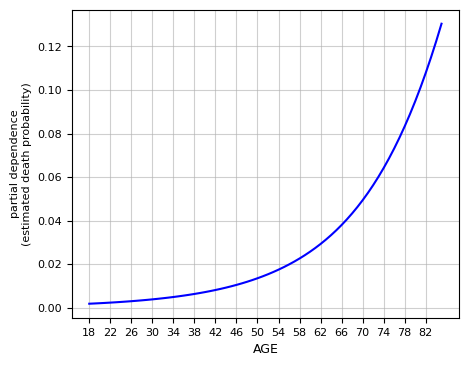

In [14]:
feature = 'AGE'
index = feature_names.index(feature)  

fit_and_plot_pdp_standadized(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, dots=4, 
                             ymin=None, ymax=None)

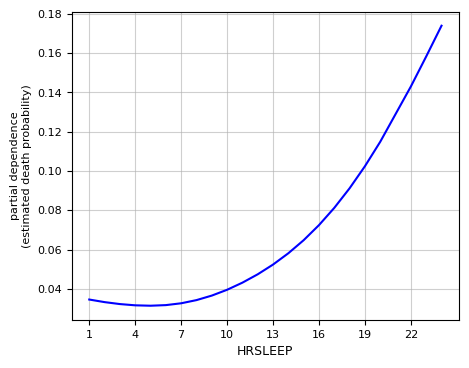

In [15]:
feature = 'HRSLEEP'
index = feature_names.index(feature)  

fit_and_plot_pdp_standadized(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, dots=3, 
                             ymin=None, ymax=None)

In [16]:
# get mins and maxs used in normalization
min_max_dict = {}

# loop through the steps in the mapper
for entry in x_mapper.features:
    columns, transformer = entry
    
    # only MinMaxScaler entries
    if isinstance(transformer, MinMaxScaler):
        col = columns[0]  
        min_val = transformer.data_min_[0]
        max_val = transformer.data_max_[0]
        min_max_dict[col] = {'min': min_val, 'max': max_val}

In [17]:
def fit_and_plot_pdp_minmax(model, x, y, feature_index, feature_name, dots, min_max_dict, ymin, ymax):
    # get the feature range from training data
    feature_values = np.sort(np.unique(x_train[:, feature_index]))
    x_np = x.detach().cpu().numpy() if torch.is_tensor(x) else x
    y_np = y.detach().cpu().numpy() if torch.is_tensor(y) else y

    # compute PDP
    pdp_values = []
    x_temp = x_np.copy()
    
    for val in feature_values:
        x_temp[:, feature_index] = val
        with torch.no_grad():
            preds = model.predict(torch.tensor(x_temp, dtype=torch.float32)).numpy().squeeze()
            probs = 1 / (1 + np.exp(-preds))  
            pdp_values.append(probs.mean())
    
    # plot PDP
    plt.figure(figsize=(5, 4))
    plt.plot(feature_values, pdp_values, color='blue', linestyle='-')
    plt.xlabel(feature_name, fontsize=9)
    plt.yticks(fontsize=8)
    
    # invert min-max scaling for x-axis tick labels
    min_val = min_max_dict[feature_name]['min']
    max_val = min_max_dict[feature_name]['max']
    
    ticks_scaled = np.sort(np.unique(x_train[:, feature_index]))
    ticks_real = min_val + (max_val - min_val) * ticks_scaled
    
    # pick real x-tick positions every `dots` units
    min_tick = int(np.floor(ticks_real.min()))
    max_tick = int(np.ceil(ticks_real.max()))
    tick_locs_real = np.arange(min_tick, max_tick + 1, dots)
    
    # convert real values back to scaled values for tick positions
    tick_locs_scaled = (tick_locs_real - min_val) / (max_val - min_val)
    plt.ylim(ymin, ymax) 
    plt.xticks(tick_locs_scaled, [str(tick) for tick in tick_locs_real], fontsize=8)
    plt.ylabel('partial dependence\n(estimated death probability)', fontsize=8)
    plt.grid(alpha=0.6)
    plt.savefig(f"pdp_minmax_{feature_name}.jpg", format="jpg", dpi=300, bbox_inches='tight')
    plt.show()

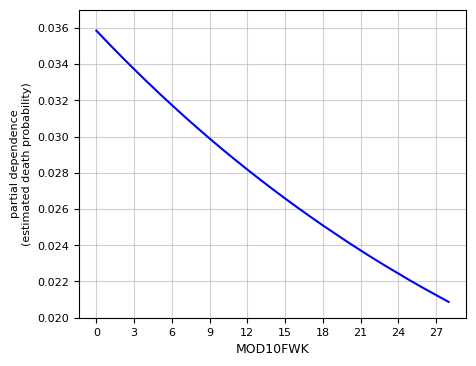

In [18]:
feature = 'MOD10FWK'
index = feature_names.index(feature)  

fit_and_plot_pdp_minmax(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, dots=3,
                        min_max_dict=min_max_dict, ymin=0.020, ymax=0.037)

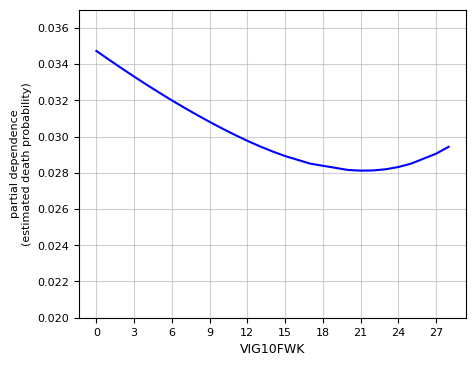

In [19]:
feature = 'VIG10FWK'
index = feature_names.index(feature)  

fit_and_plot_pdp_minmax(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, dots=3,
                        min_max_dict=min_max_dict, ymin=0.020, ymax=0.037)

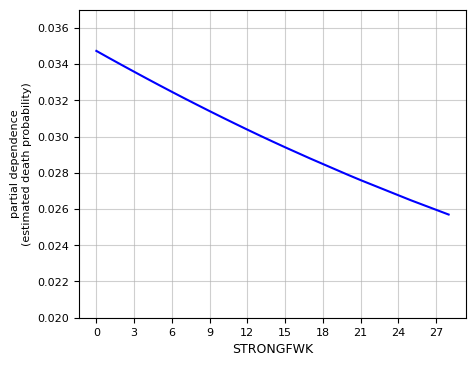

In [20]:
feature = 'STRONGFWK'
index = feature_names.index(feature)  

fit_and_plot_pdp_minmax(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, dots=3,
                        min_max_dict=min_max_dict, ymin=0.020, ymax=0.037)

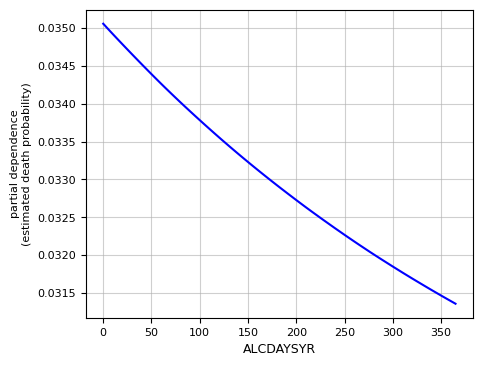

In [21]:
feature = 'ALCDAYSYR'
index = feature_names.index(feature)  

fit_and_plot_pdp_minmax(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, dots=50,
                        min_max_dict=min_max_dict, ymin=None, ymax=None)

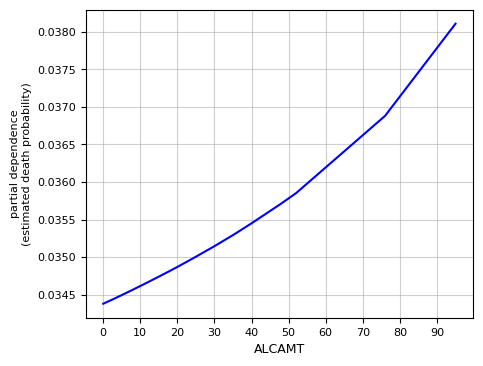

In [22]:
feature = 'ALCAMT'
index = feature_names.index(feature)  

fit_and_plot_pdp_minmax(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, dots=10, 
                        min_max_dict=min_max_dict, ymin=None, ymax=None)

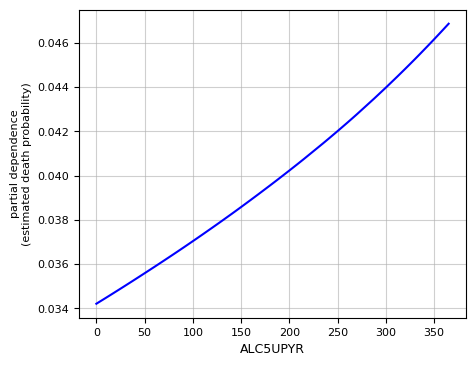

In [23]:
feature = 'ALC5UPYR'
index = feature_names.index(feature)  

fit_and_plot_pdp_minmax(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, dots=50, 
                        min_max_dict=min_max_dict, ymin=None, ymax=None)

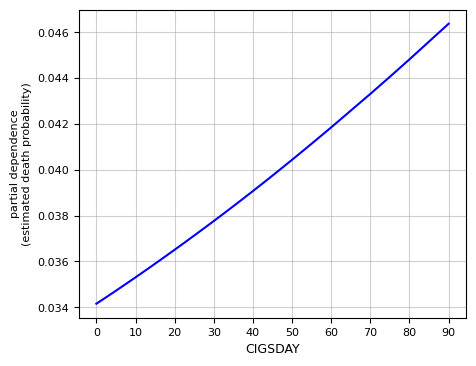

In [24]:
feature = 'CIGSDAY'
index = feature_names.index(feature)  

fit_and_plot_pdp_minmax(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, dots=10, 
                        min_max_dict=min_max_dict, ymin=None, ymax=None)

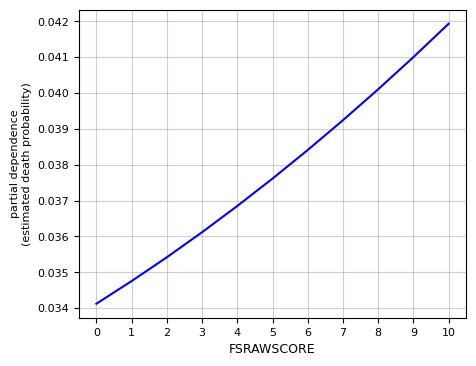

In [25]:
feature = 'FSRAWSCORE'
index = feature_names.index(feature)  

fit_and_plot_pdp_minmax(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, dots=1, 
                        min_max_dict=min_max_dict, ymin=None, ymax=None)

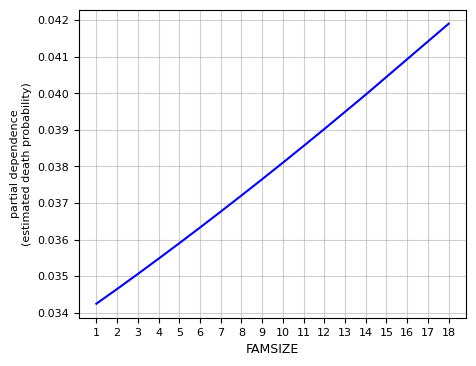

In [26]:
feature = 'FAMSIZE'
index = feature_names.index(feature)  

fit_and_plot_pdp_minmax(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, dots=1, 
                        min_max_dict=min_max_dict, ymin=None, ymax=None)

In [27]:
def fit_and_plot_pdp_categorical(model, x, y, feature_index, feature_name, custom_labels, ymin, ymax, width):
    # get the feature range from training data
    feature_values = np.sort(np.unique(x_train[:, feature_index]))
    x_np = x.detach().cpu().numpy() if torch.is_tensor(x) else x
    y_np = y.detach().cpu().numpy() if torch.is_tensor(y) else y

    # compute PDP
    pdp_values = []
    x_temp = x_np.copy()
    
    for val in feature_values:
        x_temp[:, feature_index] = val
        with torch.no_grad():
            preds = model.predict(torch.tensor(x_temp, dtype=torch.float32)).numpy().squeeze()
            probs = 1 / (1 + np.exp(-preds))  
            pdp_values.append(probs.mean())
    
    # plot PDP
    plt.figure(figsize=(5, 4))
    plt.bar(feature_values, pdp_values, color='blue', width=width)  
    plt.xlabel(feature_name, fontsize=9)
    plt.xticks(ticks=feature_values, labels=list(custom_labels.values()), fontsize=9)
    plt.yticks(fontsize=8)
    plt.xlim(-0.3, 1.3) 
    plt.ylabel('partial dependence\n(estimated death probability)', fontsize=8)
    y_ticks = np.arange(ymin, ymax, 0.005)
    plt.yticks(y_ticks, fontsize=8) 
    plt.ylim(ymin, ymax)
    plt.grid(alpha=0.6)
    plt.savefig(f"pdp_ph_{feature_name}.jpg", format="jpg", dpi=300, bbox_inches='tight')
    plt.show()

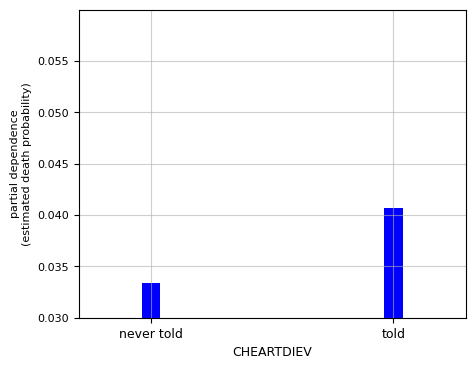

In [28]:
custom_labels = {0: "never told", 1: "told"} 
feature = 'CHEARTDIEV'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

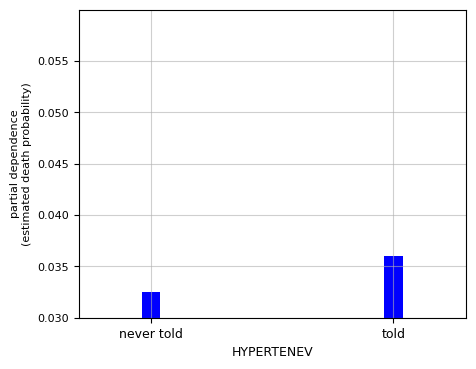

In [29]:
custom_labels = {0: "never told", 1: "told"} 
feature = 'HYPERTENEV'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

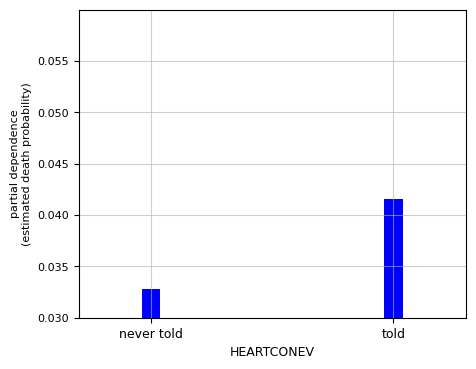

In [30]:
custom_labels = {0: "never told", 1: "told"} 
feature = 'HEARTCONEV'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

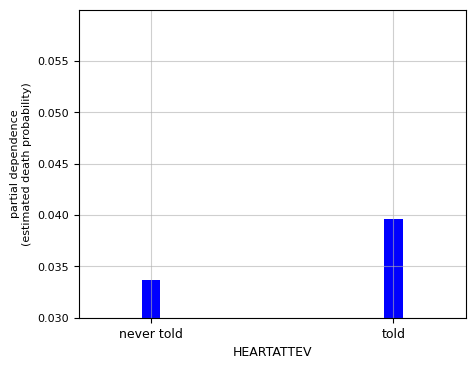

In [31]:
custom_labels = {0: "never told", 1: "told"} 
feature = 'HEARTATTEV'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

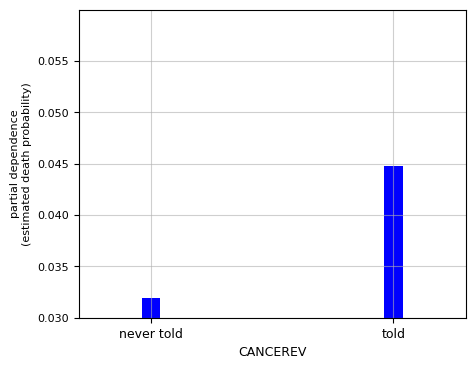

In [32]:
custom_labels = {0: "never told", 1: "told"} 
feature = 'CANCEREV'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

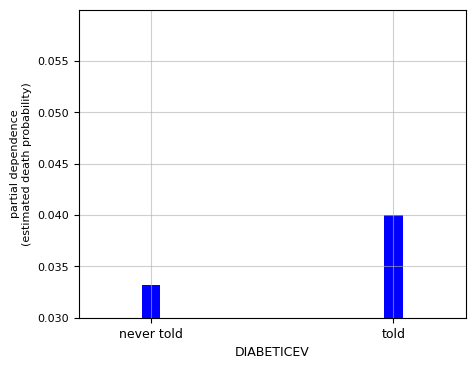

In [33]:
custom_labels = {0: "never told", 1: "told"} 
feature = 'DIABETICEV'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

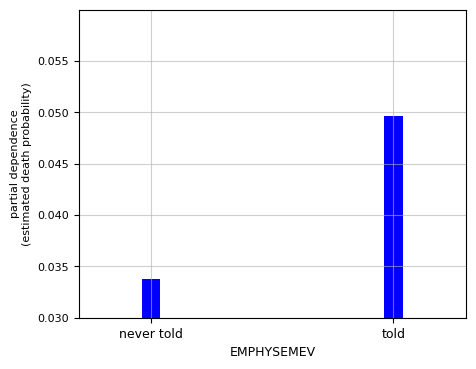

In [34]:
custom_labels = {0: "never told", 1: "told"} 
feature = 'EMPHYSEMEV'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

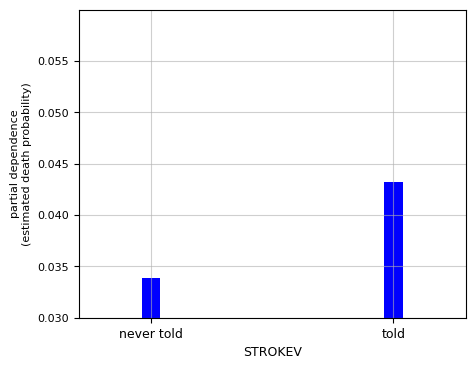

In [35]:
custom_labels = {0: "never told", 1: "told"} 
feature = 'STROKEV'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

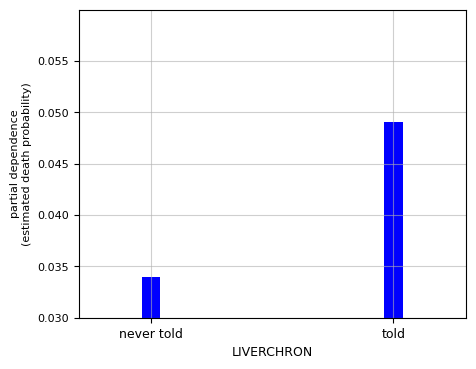

In [36]:
custom_labels = {0: "never told", 1: "told"} 
feature = 'LIVERCHRON'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

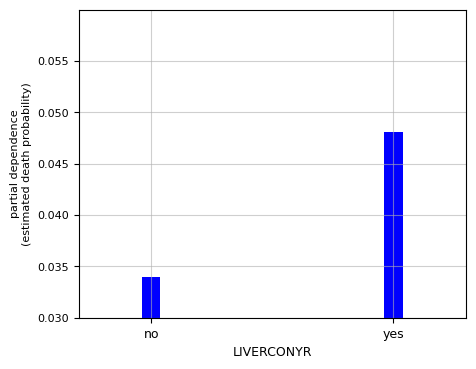

In [37]:
custom_labels = {0: 'no', 1: "yes"} 
feature = 'LIVERCONYR'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

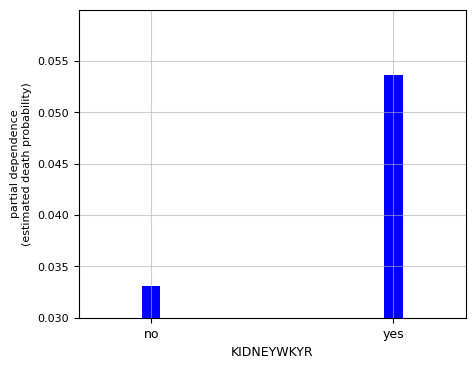

In [38]:
custom_labels = {0: "no", 1: "yes"} 
feature = 'KIDNEYWKYR'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

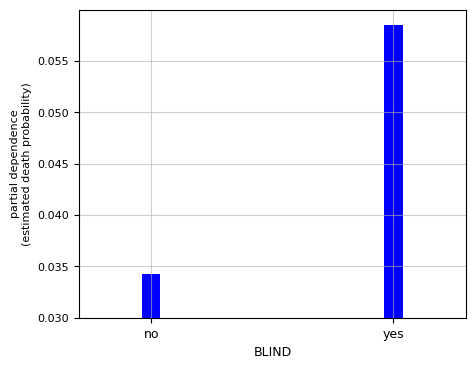

In [39]:
custom_labels = {0: "no", 1: "yes"} 
feature = 'BLIND'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

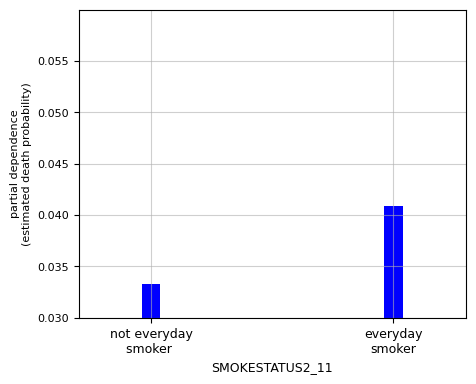

In [40]:
custom_labels = {0: "not everyday\nsmoker ", 1: "everyday\nsmoker"} 
feature = 'SMOKESTATUS2_11'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                     ymin=0.03, ymax=0.06, width=0.075)

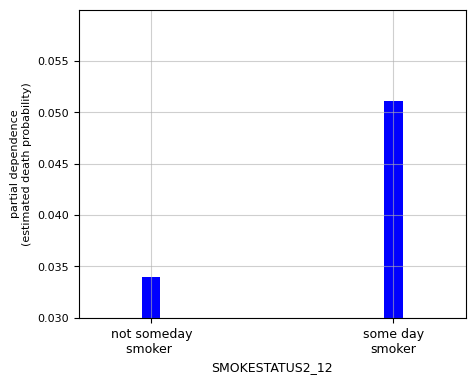

In [41]:
custom_labels = {0: "not someday\nsmoker ", 1: "some day\nsmoker"} 
feature = 'SMOKESTATUS2_12'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

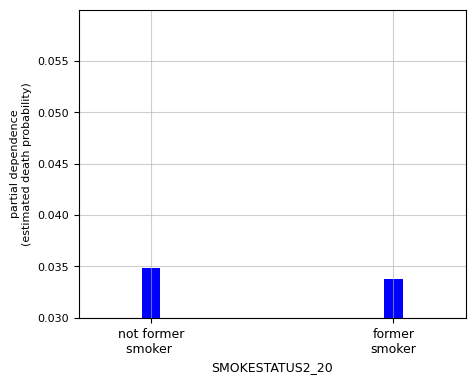

In [42]:
custom_labels = {0: "not former\nsmoker ", 1: "former\nsmoker"} 
feature = 'SMOKESTATUS2_20'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

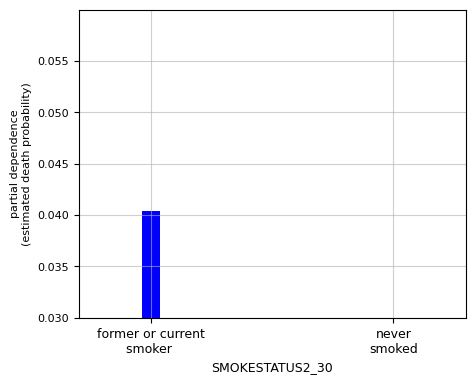

In [43]:
custom_labels = {0: "former or current\nsmoker ", 1: "never\nsmoked"} 
feature = 'SMOKESTATUS2_30'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

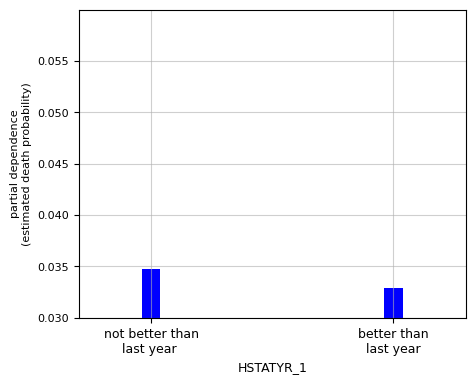

In [44]:
custom_labels = {0: "not better than\nlast year ", 1: "better than\nlast year"} 
feature = 'HSTATYR_1'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

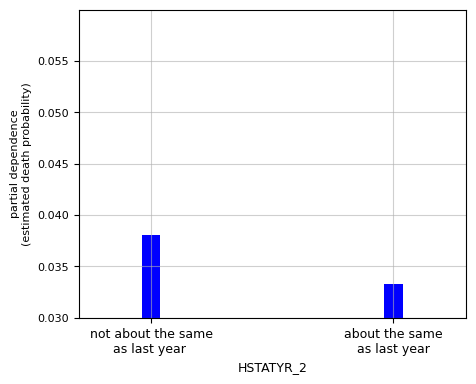

In [45]:
custom_labels = {0: "not about the same\nas last year ", 1: "about the same\nas last year"} 
feature = 'HSTATYR_2'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

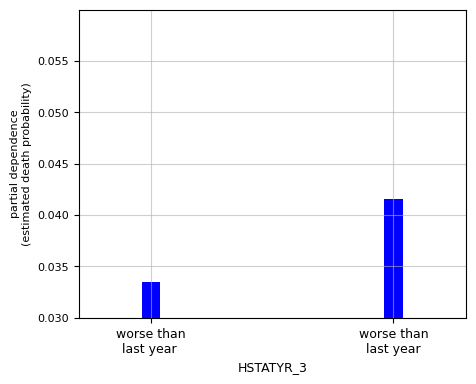

In [46]:
custom_labels = {0: "worse than\nlast year ", 1: "worse than\nlast year"} 
feature = 'HSTATYR_3'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                      ymin=0.03, ymax=0.06, width=0.075)

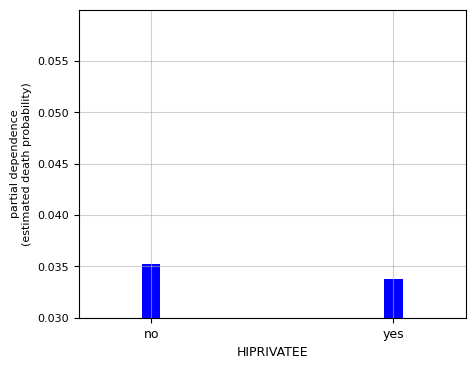

In [47]:
custom_labels = {0: "no", 1: "yes"} 
feature = 'HIPRIVATEE'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

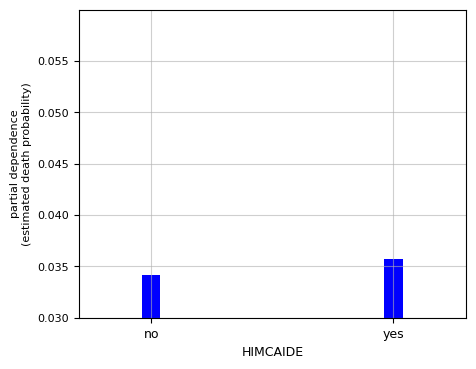

In [48]:
custom_labels = {0: "no", 1: "yes"} 
feature = 'HIMCAIDE'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

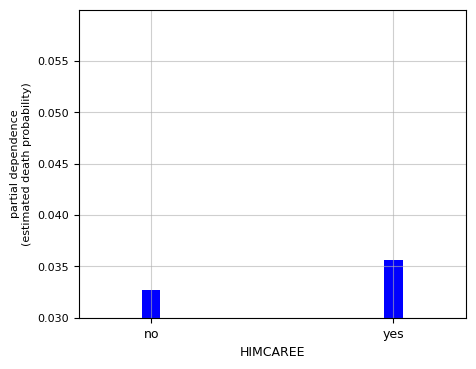

In [49]:
custom_labels = {0: "no", 1: "yes"} 
feature = 'HIMCAREE'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

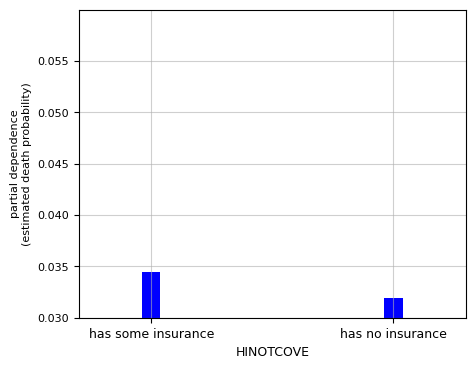

In [50]:
custom_labels = {0: "has some insurance", 1: "has no insurance"} 
feature = 'HINOTCOVE'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                    ymin=0.03, ymax=0.06, width=0.075)

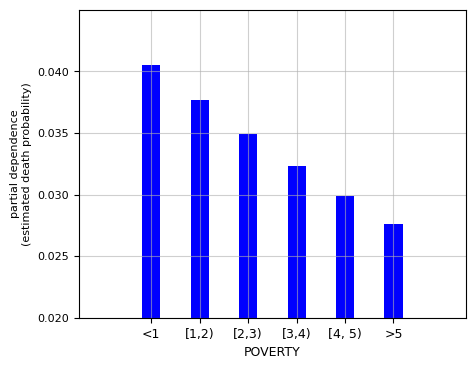

In [51]:
custom_labels = {0: "<1", 0.2: "[1,2)", 0.4: "[2,3)", 0.6: "[3,4)", 0.8:"[4, 5)", 1:">5"} 
feature = 'POVERTY'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, custom_labels=custom_labels,
                     ymin=0.02, ymax=0.045, width=0.075)

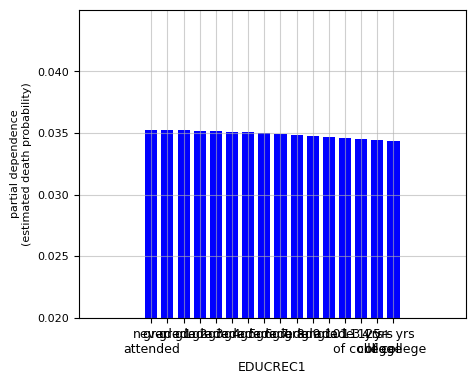

In [53]:
custom_labels = {
    1: 'never\nattended',
    2: 'grade 1',
    3: 'grade 2',
    4: 'grade 3',
    5: 'grade 4',
    6: 'grade 5',
    7: 'grade 6',
    8: 'grade 7',
    9: 'grade 8',
    10: 'grade 9',
    11: 'grade 10',
    12: 'grade 11',
    13: 'grade 12',
    14: '1-3 yrs\n of college',
    15: '4 yrs\n college',
    16: '5+ yrs\n of college'} 
feature = 'EDUCREC1'
index = feature_names.index(feature)  

fit_and_plot_pdp_categorical(model=model, x=x_test, y=y_test, feature_index=index, feature_name=feature, 
                             custom_labels=custom_labels,ymin=0.02, ymax=0.045, width=0.05) 